<a href="https://colab.research.google.com/github/sio-co2o2/keelingcurve_notebooks/blob/main/notebooks/plot_mlo_one_month_keelingcurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot last month of CO2 at Mauna Loa, Hawaii

### The Keeling Curve
https://keelingcurve.ucsd.edu

This notebook creates pdf and png plot versions.

## Import packages

In [ ]:
import re
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
from matplotlib import rc,rcParams
from matplotlib.path import Path
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
import matplotlib.transforms
from google.colab import files
from matplotlib import animation
from ipywidgets import widgets
from IPython.display import HTML
from base64 import b64encode

%matplotlib inline

## Set directories and file names for data,  plot, and logo

In [ ]:
# Read in data from github repository
data_file = 'https://raw.githubusercontent.com/sio-co2o2/keelingcurve_notebooks/main/data/mlo/mlo_one_month_span.csv'

logo_file = 'https://github.com/sio-co2o2/keelingcurve_notebooks/raw/main/images/sio_logo.png'

plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

plot_basename = 'mlo_one_month'

pdf_file = plot_dir / f"{plot_basename}.pdf"
png_file = plot_dir / f"{plot_basename}.png"

## Load in Data and process

In [ ]:
# weekly spline is a spline fit to monthly data on a weekly timescale
# to the last week less than the last plot date
df = pd.read_csv(data_file,sep=',',comment='"')
df.head()

,date_hr,co2_hr,date_dy,co2_dy,date_wk,co2_wk
0,2021.860316,414.90,2021.861644,415.29,2021.865753,414.77
1,2021.860354,414.89,2021.864384,415.44,2021.884932,414.91
2,2021.860377,414.93,2021.867123,414.51,2021.904110,415.58
3,2021.860457,414.97,2021.869863,414.36,2021.923288,415.77
4,2021.860546,414.91,2021.872603,414.39,2021.942466,415.91


### Break into dataframes for each time frequency

In [ ]:
df_hourly = df[['date_hr', 'co2_hr']].copy()
df_daily = df[['date_dy', 'co2_dy']].copy()
df_wk = df[['date_wk', 'co2_wk']].copy()

### Remove rows with fill values NaN

In [ ]:
df_hourly = df_hourly[df_hourly['co2_hr'].notnull()]
df_daily = df_daily[df_daily['co2_dy'].notnull()]
df_weekly = df_wk[df_wk['co2_wk'].notnull()]

### Convert to numpy arrays for plotting

In [ ]:
date_hourly = df_hourly['date_hr'].to_numpy()
co2_hourly = df_hourly['co2_hr'].to_numpy()
date_daily = df_daily['date_dy'].to_numpy()
co2_daily = df_daily['co2_dy'].to_numpy()
date_weekly = df_weekly['date_wk'].to_numpy()
co2_weekly = df_weekly['co2_wk'].to_numpy()

### Convert decimal year to datetime for plotting

In [ ]:
#  https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + timedelta(seconds=seconds)

In [ ]:
datetime_hourly = np.array([t2dt(x) for x in date_hourly])
datetime_daily = np.array([t2dt(x) for x in date_daily])
datetime_weekly = np.array([t2dt(x) for x in date_weekly])

## Define plot functions

In [ ]:
# https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib
# Modified to add gradient below curve and have a bottom alpha

# def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
def gradient_fill(x, y, fill_color='#FFFFFF', xmin=None, ymin=None, xmax=None, 
                  ymax=None, alpha_bottom=None, ax=None, alpha=1, zorder=1, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    # Only want the gradient to show
    #line, = ax.plot(x, y, **kwargs)
    #if fill_color is None:
    #    fill_color = line.get_color()

    if alpha_bottom is None:
        alpha_bottom = 0

    if xmin is None:
        xmin = x.min()

    if ymin is None:
        ymin = y.min()
        
    if xmax is None:
        xmax = x.max()

    if ymax is None:
        ymax = y.max()
        
    if zorder is None:
        zorder = 1
        
    #zorder = line.get_zorder()
    
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    #z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]
    z[:, :, -1] = np.linspace(alpha_bottom, alpha, 100)[:, None]

    #xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
    ax.autoscale(True)
    
    #return line, im

In [ ]:
def set_matplotlib_properties():
    
    # Set default properties for matplotlib
    
    # Reset rcparams in case modified defaults in another notebook during same session 
    plt.rcParams.update(plt.rcParamsDefault)

    plt.rcParams.update({'axes.linewidth':1.5})
    
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.weight":  "normal",
        "font.sans-serif": ["Arial", "Tahoma", "Helvetica","FreeSans", "NimbusSans", "LiberationSans","DejaVu Sans"],
        "mathtext.default":'regular',
        "mathtext.fontset": "dejavusans"
    })
        
    # http://phyletica.org/matplotlib-fonts/
    # This causes matplotlib to use Type 42 (a.k.a. TrueType) fonts 
    # for PostScript and PDF files. This allows you to avoid Type 3 fonts.
    # Turning on usetex also works
    # Needed on Ubuntu for pdf fonts 
    plt.rcParams.update({
      'pdf.fonttype': 42,
        'ps.fonttype': 42 
    })

In [ ]:
def set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel):

    
    # ------------------------------------
    # Set properties to use for matplotlib
    # ------------------------------------
    
    set_matplotlib_properties()
    
    # ---------------------------------
    # Plot properties for website plots
    # ---------------------------------

    # Allow room at top for the 2 titles
    fig.subplots_adjust(top=0.85)

    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)

    ax.tick_params(axis='x', labelsize=12, pad=5)
    ax.tick_params(axis='y', labelsize=16)

    ax.tick_params(axis='x', which='major', direction='in', length=6, width=1)
    ax.tick_params(axis='y', which='major', direction='in', length=8, width=1)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d'))
    
    fmt_every_day = mdates.DayLocator(interval=1)
    ax.xaxis.set_major_locator(fmt_every_day)
    
    tick_spacing = 5
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels: label.set_fontweight('bold') 

    ax.tick_params(which='minor', direction='in', length=4)
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    
    ax.tick_params(axis='x', which='minor', bottom=False)
    
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=18, labelpad=5)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=18, labelpad=5)

    # Set axes limits last 
    # If did before, setting xtick labels past xmin & xmax would have
    # extended the plot limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

In [ ]:
def create_xtick_labels(ax, xmin, xmax):
    
    # Move tick labels so left aligned with tick mark
    # to represent the day as starting at the tick mark
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("left")
        
    # Place the starting and ending months below the xaxis tick labels
    start_month = xmin.month
    start_month = date(1900, start_month, 1).strftime('%b')

    label_text = start_month
    ax.annotate(label_text, xy=(0, -0.06), xycoords='axes fraction', fontsize=10, fontweight='bold',
                horizontalalignment='left', verticalalignment='top')

    end_month = xmax.month
    end_month = date(1900, end_month, 1).strftime('%b')
    
    label_text = end_month
    ax.annotate(label_text, xy=(0.97, -0.06), xycoords='axes fraction', fontsize=10, fontweight='bold',
                horizontalalignment='left', verticalalignment='top')

    ax.tick_params(axis='x', pad=7)

In [ ]:
def add_plot_title(ax, title1, title2):

    ax.annotate(title1, xy=(0, 1.15), xycoords='axes fraction', fontsize=14,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")
    ax.annotate(title2, xy=(0, 1.07), xycoords='axes fraction', fontsize=18,
                horizontalalignment='left', verticalalignment='top', fontweight = 'bold')

In [ ]:
def add_inset_label(ax, label_start, today):
    label_text = f"{label_start} ending {today}"
    ax.annotate(label_text, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top')

In [ ]:
def add_legend_labels(ax):

    legend_1 = 'Hourly average'
    legend_2 = 'Daily average'
    legend_3 = 'Weekly average'
    
    legend_properties = {'weight':'bold'}

    gray = '#666666'
    gray_dot = mlines.Line2D([], [], marker = 'o', color=gray,markersize=4, 
             markerfacecolor=gray, markeredgecolor=gray, markeredgewidth=0, linestyle='None')

    black_filled_circle = mlines.Line2D([], [], marker = 'o', color='black',markersize=6, 
             markerfacecolor='black', markeredgecolor='black', markeredgewidth=0, linestyle='None')
   
    black_filled_circle_lg = mlines.Line2D([], [], marker = 'o', color='black',markersize=9, 
             markerfacecolor='black', markeredgecolor='black', markeredgewidth=0, linestyle='None')
   
    # Use best placement for legend
    plt.rc('legend',fontsize=12)
    ax.legend([gray_dot, black_filled_circle, black_filled_circle_lg], 
              [legend_1, legend_2, legend_3],frameon=False,borderaxespad=1,
              labelspacing=0.2, prop=legend_properties)

In [ ]:
def add_sio_logo(fig, logo_file, xpos, ypos):

    logo = mpimg.imread(logo_file)

    fig.add_axes([xpos, ypos, 0.2, 0.2], anchor='SE', zorder=1)

    plt.imshow(logo)
    plt.axis('off')

In [ ]:
def save_plot_for_website(fig, pdf_file, png_file):

    # For pdf
    width_in = 11
    height_in = 8.5
    fig.set_size_inches(width_in, height_in, forward=True)

    plt.subplots_adjust(left=0.1, right=0.11, top=0.8, bottom=0.2)

    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, pad_inches=0)

    # For png
    width_px = 1000
    height_px = (height_in/width_in) * width_px

    png_dpi = 100
    fig.set_size_inches(width_px/png_dpi, height_px/png_dpi)

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, pad_inches=0)

## Set plot limits and labeling

### Functions to convert dates into various formats
For plot limits and labeling

In [ ]:
# Function to convert datetime to a float
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

In [ ]:
def get_todays_date_variations():
    
    now = datetime.now()
    todays_decimal =  dt2t(now)
    
    today = date.today()

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year

In [ ]:
def get_data_end_date(date_data):
    last_date = np.max(date_data)
    last_date_datetime = t2dt(last_date)
    
    # Convert date format to month_name day, year
    day = last_date_datetime.day
    month = last_date_datetime.strftime("%B")
    year = last_date_datetime.year
    date_modyyr = f"{month} {day}, {year}"
    return date_modyyr

### Set titles and axes labels

In [ ]:
xlabel = ''
ylabel = "$\mathregular{CO}\\bf{_2}$" + " Concentration (ppm)"

title1 = get_data_end_date(date_daily)
title2 = 'Carbon dioxide concentration at Mauna Loa Observatory'

### Set yaxis min and max limits

In [ ]:
ymin = 405
ymax = 430

### Set xaxis min and max limits as both dates and decimals

In [ ]:
now = datetime.now()
time_ago = now + relativedelta(months=-1)

xmin = time_ago
xmax = now

## Create plot and save

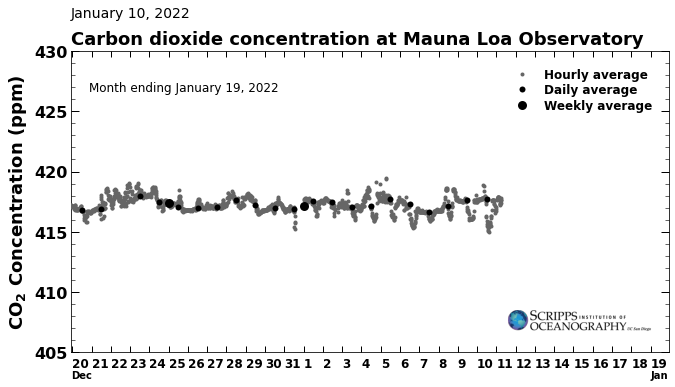

In [ ]:
fig = plt.figure()

# Add padding for exterior plot text
ax = plt.axes([0.11, 0.12, 0.83, 0.54])
              

# -------------
# Plot the data
# -------------

gray = '#666666'
ax.plot(datetime_hourly, co2_hourly, 'o', color=gray,markersize=4, 
         markerfacecolor=gray, markeredgecolor=gray, markeredgewidth=0, zorder=5)

ax.plot(datetime_daily, co2_daily, 'o', color='black',markersize=6, 
         markerfacecolor='black', markeredgecolor='black', markeredgewidth=0, zorder=6)

ax.plot(datetime_weekly, co2_weekly, 'o', color='black',markersize=9, 
         markerfacecolor='black', markeredgecolor='black', markeredgewidth=0, zorder=7)


# -----------------------------------------------------
# Change xaxis to use date labels and not decimal dates
# -----------------------------------------------------
create_xtick_labels(ax, xmin, xmax)


# -------------------
# Set plot properties
# -------------------
set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel)


# ------------------------------------------------
# Get todays date in various formats for labeling
# ------------------------------------------------
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()


# ---------------
# Add plot titles
# ---------------
add_plot_title(ax, title1, title2)

# --------------
# Add inset text
# --------------
add_inset_label(ax, 'Month', todays_date_modyyr)

# ----------------
# Add legend
# ----------------
add_legend_labels(ax)

# --------------------
# Add SIO logo to plot
# --------------------
xpos = 0.715
ypos = 0.155

add_sio_logo(fig, logo_file, xpos, ypos)


# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()

save_plot_for_website(fig, pdf_file, png_file)


plt.show()

## Download Plots (pdf & png)

In [ ]:
def download_files(ev):
    files.download(png_file)
    files.download(pdf_file)

button = widgets.Button(description='Download Files', button_style='primary')
button.on_click(download_files)
display(button)

Button(button_style='primary', description='Download Files', style=ButtonStyle())